In [1]:
import os
import numpy as np
import torch
from clip_retrieval.clip_client import ClipClient
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import clip
from collections import defaultdict
import pickle

/home/mateusz/anaconda3/envs/pons/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
imgs = os.listdir('data/com_images')
# raname each image by adding 6500 to the name
for i in tqdm(range(len(imgs))):
    num = int(imgs[i].split('.')[0]) + 6500
    os.rename('data/com_images/' + imgs[i], 'data/com_images/' + str(num) + '.jpg')

100%|██████████| 1772/1772 [00:00<00:00, 64237.19it/s]


In [2]:
#client = ClipClient(url="https://knn.laion.ai/knn-service", indice_name="laion5B-H-14")

model_name = ['ViT-L/14','RN50x16','RN50']

device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = []
preprocesses = []
for model_name in model_name:
    model, preprocess = clip.load(model_name, device=device)
    models.append(model)
    preprocesses.append(preprocess)

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
items = ['shoe', 'handbag', 'nail polish', 'hat', 't shirt', 'coat','perfume','belt', 'sunglasses', 'watch', 'jewelry', 'scarf', 'gloves', 'wallet', 'makeup']
brands = ['gucci', 'prada', 'chanel', 'dior', 'versace', 'nike', 'puma',
         'adidas', 'ralph lauren', 'armani', 'dolce & gabbana',
         'max factor', 'loreal', 'calvin klein', 'converse','']
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'black',
                'white', 'grey', 'brown', 'beige', 'gold', 'silver', 'multicolor']

full_description = [f"commercial photo of {color} {brand} {item}" for item in items for brand in brands for color in colors]


descriptions_tokens = []

descriptions_tokens = clip.tokenize(full_description).to(device)

In [4]:
# Loop over the descriptions and embed them.
text_embeddings = []
n = 2048
for i in range(len(models)):
    with torch.no_grad():
        temp_embeddings = []
        for j in tqdm(range(0, len(descriptions_tokens), n)):
            embeds = models[i].encode_text(descriptions_tokens[j:j+n])
            temp_embeddings.append(embeds)
    text_embeddings.append(torch.cat(temp_embeddings, dim=0))

#data_embeddings = torch.stack(text_embeddings)
data_embeddings = text_embeddings

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


In [5]:
#data_embeddings = data_embeddings.to('cuda')
for i in range(len(data_embeddings)):
    data_embeddings[i] = data_embeddings[i].to('cuda')
    

In [26]:
imgs = os.listdir('data/non_dup')
len(imgs)

6752

In [27]:
# loop over the images and embed them using the models
image_embeddings = [[] for i in range(len(models))]
for i in range(len(models)):
    for img in tqdm(imgs):
        image = preprocesses[i](Image.open(f'data/non_dup/{img}')).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = models[i].encode_image(image)
        image_embeddings[i].append(image_features)

100%|██████████| 6752/6752 [02:29<00:00, 45.13it/s]


In [30]:
embeds = [torch.cat(image_embeddings[i], dim=0) for i in range(len(models))]
#for i in range(len(embeds)):
    #embeds[i] = embeds[i].to('cuda')
embeds[0].shape

torch.Size([6752, 768])

In [31]:
duplicates = defaultdict(list)
for i in tqdm(range(len(embeds[0]))):
    cur_embed = embeds[0][i]
    sim = torch.nn.functional.cosine_similarity(embeds[0], cur_embed)
    top_k = torch.topk(sim, 10)
    for j in range(10):
        score, idx = top_k.values[j], top_k.indices[j]
        if score > 0.99 and idx != i and idx.item() not in duplicates:
            duplicates[i].append(idx.item())

100%|██████████| 6752/6752 [00:05<00:00, 1262.32it/s]


In [24]:
duplicates = set()
for i in tqdm(range(len(embeds[0]))):
    cur_embed = embeds[0][i]
    sim = torch.nn.functional.cosine_similarity(embeds[0], cur_embed)
    top_k = torch.topk(sim, 15)
    for j in range(15):
        score, idx = top_k.values[j], top_k.indices[j]
        if score > 0.99 and idx != i and idx.item() not in duplicates:
            duplicates.add(idx.item())
    if i not in duplicates:
        path = f"data/non_dup"
        img = Image.open(f'data/brand_com_images/{imgs[i]}')
        img.save(f'{path}/{imgs[i]}')
    duplicates.add(i)

100%|██████████| 8139/8139 [00:41<00:00, 197.23it/s]


In [25]:
len(os.listdir('data/non_dup'))

6752

In [11]:
test_img = "data/a817ba29-e588-4957-b690-4b79e396b23c.jpg"
img = Image.open(test_img)
tokens_1 = preprocesses[0](img).unsqueeze(0).to(device)
tokens_2 = preprocesses[1](img).unsqueeze(0).to(device)
with torch.no_grad():
    image_features_1 = models[0].encode_image(tokens_1)
    image_features_2 = models[1].encode_image(tokens_2)

sim_1 = torch.cosine_similarity(data_embeddings[0], image_features_1)
sim_2 = torch.cosine_similarity(data_embeddings[1], image_features_2)
print(full_description[sim_1.argmax()], full_description[sim_2.argmax()])

commercial photo of red ralph lauren nail polish commercial photo of orange max factor nail polish


In [8]:
del temp_embeddings, text_embeddings, descriptions_tokens

In [9]:
imgs = os.listdir('data/brand_com_images')
len(imgs)

6367

In [12]:
img_scores = []
img_tags = []
img_embeddings = [[] for i in range(len(models))]
for i in tqdm(range(len(imgs))):
    img = Image.open(f'data/brand_com_images/{imgs[i]}')
    #img = preprocesses[0](img).unsqueeze(0).to(device)
    top_3_scores = 0
    voting = defaultdict(float)
    for model_i in range(len(models)):
        with torch.no_grad():
            query_tokens = preprocesses[model_i](img).unsqueeze(0).to(device)   
            query_embedding = models[model_i].encode_image(query_tokens)
            img_embeddings[model_i].append(query_embedding)

            similarity = torch.nn.functional.cosine_similarity(data_embeddings[model_i], query_embedding)
            # get the top 3 most simialr data points
            top_10 = torch.topk(similarity, 10).indices
            scores = torch.topk(similarity, 10).values
            for j in range(10):
                voting[full_description[top_10[j]]] += scores[j].item()
       # top_3_scores += torch.sum(scores[:3]).item()
    #print(tags)
    #plt.imshow(img)
    # sort the tags by the voting
    tags = []
    scores = []
    voting = sorted(voting.items(), key=lambda x: x[1], reverse=True)
    for tag, score in voting[:3]:
        tags.append(tag)
        scores.append(score)
        #print(tag, score)
    img_tags.append(tags)
    img_scores.append(scores)
#voting, len(voting)

100%|██████████| 6367/6367 [08:24<00:00, 12.63it/s]


In [15]:
embeds = [torch.cat(img_embeddings[i], dim=0) for i in range(len(models))]
#for i in range(len(embeds)):
    #embeds[i] = embeds[i].to('cuda')
embeds[0].shape

torch.Size([6367, 768])

In [37]:
# loop over embeds[0] and look for duplicates by comparing embeddings
duplicates = defaultdict(list)
for i in tqdm(range(len(embeds[0]))):
    cur_embed = embeds[0][i]
    sim = torch.nn.functional.cosine_similarity(embeds[0], cur_embed)
    top_k = torch.topk(sim, 10)
    for j in range(10):
        score, idx = top_k.values[j], top_k.indices[j]
        if score > 0.99 and idx != i and idx.item() not in duplicates:
            duplicates[i].append(idx.item())

100%|██████████| 6367/6367 [00:04<00:00, 1337.21it/s]


In [39]:
len(duplicates)

1112

In [ ]:
duplicates
for key in duplicates:
    print('--------------------------------------')
    #plt.imshow(Image.open(f'data/brand_com_images/{imgs[key]}'))
    #plt.show()
    for idx in duplicates[key]:
        plt.imshow(Image.open(f'data/brand_com_images/{imgs[idx]}'))
        plt.show()
    

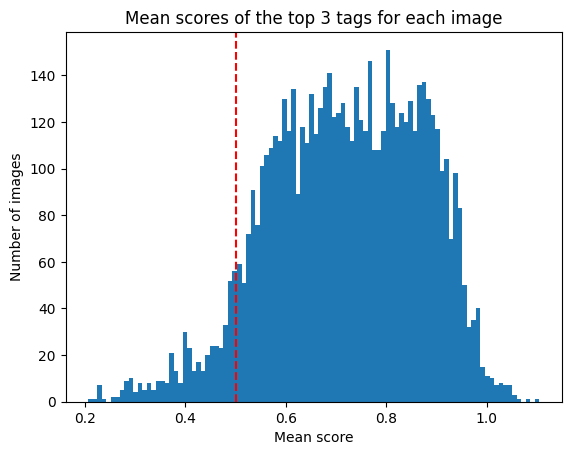

In [16]:
mean_scores = np.mean(img_scores, axis=1)
mean_scores.shape
plt.hist(mean_scores, bins=100);
plt.title('Mean scores of the top 3 tags for each image')
plt.xlabel('Mean score')
plt.ylabel('Number of images')
# add a red line to show the threshold
plt.axvline(x=0.5, color='r', linestyle='--')

In [20]:
pickle.dump(img_tags, open('temp_data/img_tags.pt', 'wb'))
pickle.dump(img_scores, open('temp_data/img_scores.pt', 'wb'))

['red adidas handbag', 'red puma handbag', 'red loreal handbag']
[0.864990234375, 0.861328125, 0.84130859375]


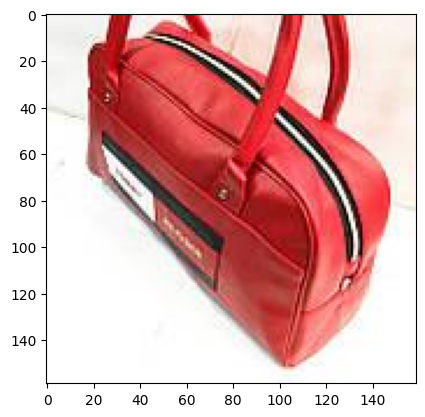

In [24]:
idx = np.random.randint(0, len(imgs))
print(img_tags[idx])
print(img_scores[idx])
plt.imshow(Image.open(f'temp_imgs/{imgs[idx]}'))

In [98]:
i = 0
for score in img_scores:
    if score < 1.0:
        i += 1
print(round(i/len(img_scores)*100, 2))

0.08


In [15]:
i = 0
wrong = []
right = []
for j, scores in enumerate(img_scores):
    score = np.mean(scores)
    if score < 0.6:
        wrong.append(j)
        i += 1
    else:
        right.append(j)
print(f"Bad images {round(len(wrong)/len(img_scores)*100, 2)}%", i)

Bad images 23.04% 1467


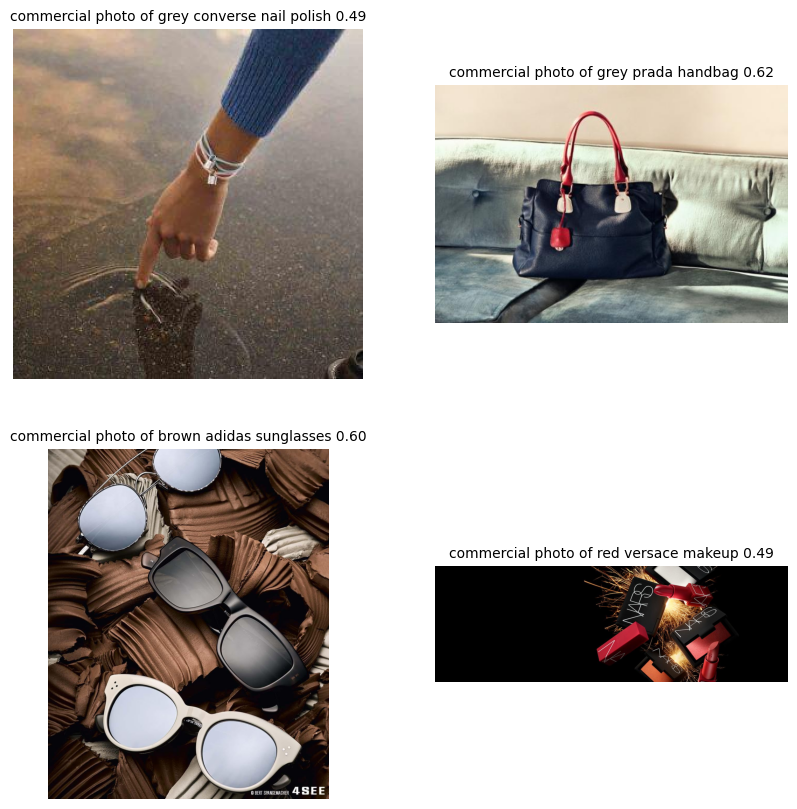

In [28]:
import random

# get 4 random images from the wrong ones and plot them in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    idx = random.randint(0, len(wrong)-1)
    img = Image.open(f'data/brand_com_images/{imgs[wrong[idx]]}')
    ax.imshow(img)
    labels = ','.join(img_tags[wrong[idx]][:1]) + f" {img_scores[wrong[idx]][0]:.2f}"
    #scores = ','.join([str(round(score, 2)) for score in img_scores[wrong[idx]]])
    score = round(img_scores[wrong[idx]][0],2)
    ax.set_title(f"{labels}", fontsize=10)
    #ax.set_title(f"{img_tags[wrong[idx]]} {img_scores[wrong[idx]]:.2f}")
    ax.axis('off')
    

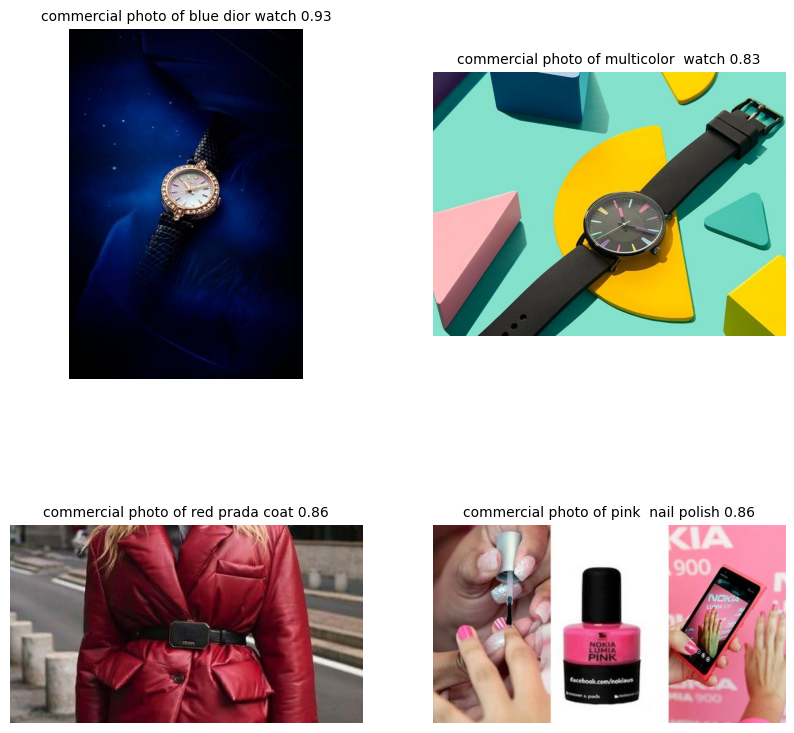

In [32]:
# get 4 random images from the right ones and plot them in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    idx = random.randint(0, len(right)-1)
    img = Image.open(f'data/brand_com_images/{imgs[right[idx]]}')
    ax.imshow(img)
    labels = ' | '.join(img_tags[right[idx]][:1]) + f" {img_scores[right[idx]][0]:.2f}"
    #scores = ','.join([str(round(score, 2)) for score in img_scores[right[idx]]])
    score = round(img_scores[right[idx]][0],2)
    ax.set_title(f"{labels}", fontsize=10)
    #ax.set_title(f"{img_tags[right[idx]]} {img_scores[right[idx]]:.2f}")
    ax.axis('off')